<a href="https://colab.research.google.com/github/Hanyan-Wu/MachineLearningLab/blob/main/NYSE%20prediction%20using%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the pandas library
import pandas as pd
# Load numpy for array manipulation
import numpy as np
# Load seaborn plotting library
import seaborn as sns
import matplotlib.pyplot as plt
# For read file from url
import io
import requests

# Set font sizes in plots
sns.set(font_scale = 1.)
# Display all columns
pd.set_option('display.max_columns', None)

# New York Stock Exchange (NYSE) data (1962-1986) (10 pts)

The [NYSE.cvs](https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv) file contains three daily time series from the New York Stock Exchange (NYSE) for the period Dec 3, 1962-Dec 31, 1986 (6,051 trading days).

- `Log trading volume` ($v_t$): This is the fraction of all outstanding shares that are traded on that day, relative to a 100-day moving average of past turnover, on the log scale.

- `Dow Jones return` ($r_t$): This is the difference between the log of the Dow Jones Industrial Index on consecutive trading days.

- `Log volatility` ($z_t$): This is based on the absolute values of daily price movements.

In [ ]:
# Read in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


Do a similar plot for (1) the correlation between $v_t$ and lag $l$ `Dow Jones return` $r_{t-l}$ and (2) correlation between $v_t$ and lag $l$ `Log volatility` $z_{t-l}$.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
# Define the maximum time lag L
L = 20

# Compute the correlation for each time lag
corr_vals_r = np.zeros(L+1)

corr_vals_r[0] = np.corrcoef(NYSE['log_volume'], NYSE['DJ_return'])[0,1]

for l in range(1,L+1):
    corr_vals_r[l] = np.corrcoef(NYSE['log_volume'][l:], NYSE['DJ_return'][:-l])[0,1]

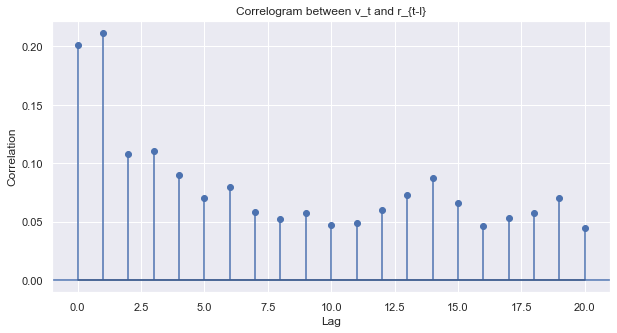

In [ ]:
# Plot the correlation like an ACF plot
fig_r, ax_r = plt.subplots(figsize=(10,5))

ax_r.stem(range(L+1), corr_vals_r, linefmt='b-', markerfmt='bo', basefmt='k-')
ax_r.axhline(y=0, color='b')
ax_r.set_xlabel('Lag')
ax_r.set_ylabel('Correlation')
ax_r.set_title('Correlogram between v_t and r_{t-l}')

plt.show()

In [ ]:
# Compute the correlation for each time lag
corr_vals_z = np.zeros(L+1)

corr_vals_z[0] = np.corrcoef(NYSE['log_volume'], NYSE['log_volatility'])[0,1]

for l in range(1, L+1):
    corr_vals_z[l] = np.corrcoef(NYSE['log_volume'][l:], NYSE['log_volatility'][:-l])[0,1]

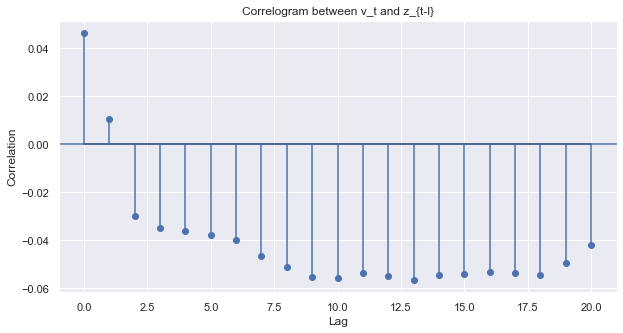

In [ ]:
# Plot the correlation like an ACF plot
fig_z, ax_z = plt.subplots(figsize=(10,5))

ax_z.stem(range(L+1), corr_vals_z, linefmt='b-', markerfmt='bo', basefmt='k-')
ax_z.axhline(y=0, color='b')
ax_z.set_xlabel('Lag')
ax_z.set_ylabel('Correlation')
ax_z.set_title('Correlogram between v_t and z_{t-l}')

plt.show()

# Project goal

Our goal is to forecast daily `Log trading volume`, using various machine learning algorithms we learnt in this class.

The data set is already split into train (before Jan 1st, 1980, $n_{train} = 4,281$) and test (after Jan 1st, 1980, $n_{test} = 1,770$) sets.

In general, we will tune the lag $L$ to acheive best forecasting performance. In this project, we would fix $L = 5$. That is we always use the previous five trading days’ data to forecast today’s `log trading volume`.

Pay attention to the nuance of splitting time series data for cross validation. Study and use the [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) in Scikit-Learn. Make sure to use the same splits when tuning different machine learning algorithms.

Use the $R^2$ between forecast and actual values as the cross validation and test evaluation crtierion.

# Baseline method (20 pts)

We use the straw man (use yesterday’s value of `log trading volume` to predict that of today) as the baseline method.

Evaluate the $R^2$ of this method on the test data.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Define X and y
X_other = NYSE[NYSE['train'] == True].copy().drop(['day_of_week', 'train'], axis = 1)
y_other = NYSE[NYSE['train'] == True]['log_volume'].values

In [ ]:
y_other

array([ 0.032573,  0.346202,  0.525306, ..., -0.137014, -0.041932,
       -0.125945])

In [ ]:
y_other.shape

(4281,)

In [ ]:
# Define TimeSeriesSplits with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# Cross Validation
cvr2_base_lst = []

for trn_index, tst_index in tscv.split(X_other):
    # Split the data into train and test sets
    X_trn, X_tst = X_other.iloc[trn_index], X_other.iloc[tst_index]
    y_trn, y_tst = y_other[trn_index], y_other[tst_index]

    # Use the previous five trading days' data to forecast today's log trading volume
    X_trn = np.array([X_trn.iloc[i-5:i].values.flatten() for i in range(5, len(X_trn)+1)])
    y_trn = y_trn[5:]
    X_tst = np.array([X_tst.iloc[i-5:i].values.flatten() for i in range(5, len(X_tst)+1)])
    y_tst = y_tst[5:]

    # Baseline model
    y_pred_base = y_tst[:-1]
    r2_base = r2_score(y_tst[1:], y_pred_base)

    # Store cvr2
    cvr2_base_lst.append(r2_base)

#Calculate the average r2
cvr2_base = np.mean(cvr2_base_lst)

In [ ]:
print(f'The CV R square of the baseline method is {round(cvr2_base,4)}.')

The CV R square of the baseline method is 0.4035.


In [ ]:
# Define the test data set
X_test = NYSE[NYSE['train'] == False].copy().drop(['day_of_week', 'train'], axis = 1)
y_test = NYSE[NYSE['train'] == False]['log_volume'].values

In [ ]:
y_test

array([ 0.117599,  0.33163 ,  0.078033, ..., -0.371237, -0.385638,
       -0.264986])

In [ ]:
y_test.shape

(1770,)

In [ ]:
# Calculate the R square on test set
y_base = y_test[:-1]
testr2_base = r2_score(y_test[1:], y_base)

In [ ]:
print(f'The test R square of the baseline method is {round(testr2_base,4)}.')

The test R square of the baseline method is 0.1807.


In [ ]:
# Store the cv r2 and test r2
r2_df = pd.DataFrame(columns=['Method', 'CV R2', 'Test R2'])

r2_df.loc[0] = ['Baseline', cvr2_base, testr2_base]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.4035,0.180737


# Autoregression (AR) forecaster (30 pts)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create the lagged feautures
def create_lagged_features(X):
    lag_v = [X['log_volume'].shift(i) for i in range(1, 6)]
    lag_v_df = pd.DataFrame(lag_v).T.dropna()
    lag_v_df.columns = ['v_lag1', 'v_lag2', 'v_lag3', 'v_lag4', 'v_lag5']

    lag_r = [X['DJ_return'].shift(i) for i in range(1, 6)]
    lag_r_df = pd.DataFrame(lag_r).T.dropna()
    lag_r_df.columns = ['r_lag1', 'r_lag2', 'r_lag3', 'r_lag4', 'r_lag5']

    lag_z = [X['log_volatility'].shift(i) for i in range(1, 6)]
    lag_z_df = pd.DataFrame(lag_z).T.dropna()
    lag_z_df.columns = ['z_lag1', 'z_lag2', 'z_lag3', 'z_lag4', 'z_lag5']

    return np.column_stack([lag_v_df, lag_r_df, lag_z_df])

In [ ]:
X_other_lagged = create_lagged_features(X_other)

In [ ]:
X_other_lagged.shape

(4276, 15)

In [ ]:
# Preprocessing: Standardization
scaler = StandardScaler()

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# Model
elastic_mod = ElasticNet()

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
# Pipeline: AR(5) with ElasitcNet
pipe_EN = Pipeline(steps=[
    ('scaler', scaler),
    ('model', elastic_mod)
])

pipe_EN

Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())])

In [ ]:
# Tune the hyper parameters

alphas_EN = np.logspace(start = -3, stop = 2, base = 10, num = 50)
l1_ratios = np.linspace(0.001, 0.1, 10)
tol_EN = [0.0001, 0.001]
random_state_EN = [42]
max_iter_EN =  [1000, 5000]

tuned_params_EN = {
    'model__alpha': alphas_EN,
    'model__l1_ratio': l1_ratios,
    'model__tol': tol_EN,
    'model__random_state': random_state_EN,
    'model__max_iter' : max_iter_EN
}

tuned_params_EN

{'model__alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
        2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
        6.55128557e-03, 8.28642773e-03, 1.04811313e-02, 1.32571137e-02,
        1.67683294e-02, 2.12095089e-02, 2.68269580e-02, 3.39322177e-02,
        4.29193426e-02, 5.42867544e-02, 6.86648845e-02, 8.68511374e-02,
        1.09854114e-01, 1.38949549e-01, 1.75751062e-01, 2.22299648e-01,
        2.81176870e-01, 3.55648031e-01, 4.49843267e-01, 5.68986603e-01,
        7.19685673e-01, 9.10298178e-01, 1.15139540e+00, 1.45634848e+00,
        1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
        4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
        1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
        3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
        7.90604321e+01, 1.00000000e+02]),
 'model__l1_ratio': array([0.001, 0.012, 0.023, 0.034, 0.045, 0.056, 0.067, 0.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Cross-validation using TimeSeriesSplit
search_EN = GridSearchCV(
    pipe_EN,
    tuned_params_EN,
    cv = tscv,
    scoring = 'r2',
    refit = True
)

In [ ]:
# Fit CV
search_EN.fit(X_other_lagged, y_other[5:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.55128557e-03, 8.28642773e-03, 1....
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02]),
                         'model__l1_ratio': array([0.001, 0.012, 0.023, 0.034, 0.045, 0.056, 0.067, 0.078, 0.089,
       0.1  ]),
                         'model__max_iter': [1000, 5000],
                         'model__random_state': [42],
                         'model__tol': [0.0001, 0.00

In [ ]:
# Results
print(f'AR(5) using ElasticNet: \n best R2: {search_EN.best_score_}, \n best parameters: {search_EN.best_params_}.')

AR(5) using ElasticNet: 
 best R2: 0.5557033786635757, 
 best parameters: {'model__alpha': 0.001, 'model__l1_ratio': 0.001, 'model__max_iter': 1000, 'model__random_state': 42, 'model__tol': 0.0001}.


In [ ]:
# Define lagged X_test
X_test_lagged = create_lagged_features(X_test)

In [ ]:
X_test_lagged.shape

(1765, 15)

In [ ]:
# Calculate the R square on test set
y_pred_EN = search_EN.best_estimator_.predict(X_test_lagged)
testr2_EN = r2_score(y_test[5:], y_pred_EN)

print(f'The test R square of the AR(5) method using ElasticNet is {round(testr2_EN,4)}.')

The test R square of the AR(5) method using ElasticNet is 0.4136.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[1] = ['AR(5) ElasticNet', search_EN.best_score_, testr2_EN]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611


# Autoregression by MLP (30 pts)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# Model: MLP
mlp_mod = MLPRegressor(
  hidden_layer_sizes = (8, 4),
  activation = 'relu',
  solver = 'adam',
  batch_size = 16,
  random_state = 425
  )

In [ ]:
# Pipeline: AR(5) with MLP
pipe_mlp = Pipeline(steps=[
    ('scaler', scaler),
    ('model', mlp_mod)
])

pipe_mlp

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPRegressor(batch_size=16, hidden_layer_sizes=(8, 4),
                              random_state=425))])

In [ ]:
# Tune hyper-parameters
hls_grid_mlp = [(4,2), (8,4), (12,6)]
bs_grid_mlp = [4, 8, 12, 16, 32]
alphas_mlp = [0.001, 0.01, 0.1]

tuned_params_mlp = {
    'model__hidden_layer_sizes': hls_grid_mlp,
    'model__batch_size': bs_grid_mlp,
    'model__alpha': alphas_mlp
}

tuned_params_mlp

{'model__hidden_layer_sizes': [(4, 2), (8, 4), (12, 6)],
 'model__batch_size': [4, 8, 12, 16, 32],
 'model__alpha': [0.001, 0.01, 0.1]}

In [ ]:
# Cross-validation
search_mlp = GridSearchCV(
    pipe_mlp,
    tuned_params_mlp,
    cv = tscv,
    scoring= 'r2',
    refit = True
)

In [ ]:
# Fit CV
search_mlp.fit(X_other_lagged, y_other[5:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        MLPRegressor(batch_size=16,
                                                     hidden_layer_sizes=(8, 4),
                                                     random_state=425))]),
             param_grid={'model__alpha': [0.001, 0.01, 0.1],
                         'model__batch_size': [4, 8, 12, 16, 32],
                         'model__hidden_layer_sizes': [(4, 2), (8, 4),
                                                       (12, 6)]},
             scoring='r2')

In [ ]:
# Results
print(f'AR(5) using MLP: \n best R2: {search_mlp.best_score_}, \n best parameters: {search_mlp.best_params_}.')

AR(5) using MLP: 
 best R2: 0.5630070482872459, 
 best parameters: {'model__alpha': 0.01, 'model__batch_size': 4, 'model__hidden_layer_sizes': (4, 2)}.


In [ ]:
# Calculate the R square on test set
y_pred_mlp = search_mlp.best_estimator_.predict(X_test_lagged)
testr2_mlp = r2_score(y_test[5:], y_pred_mlp)

print(f'The test R square of the AR(5) method using MLP is {round(testr2_mlp,4)}.')

The test R square of the AR(5) method using MLP is 0.4177.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[2] = ['AR(5) MLP', search_mlp.best_score_, testr2_mlp]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703


# LSTM forecaster (30 pts)

In [ ]:
X_other.head(10)

,DJ_return,log_volume,log_volatility
date,,,
1962-12-03,-0.004461,0.032573,-13.127403
1962-12-04,0.007813,0.346202,-11.749305
1962-12-05,0.003845,0.525306,-11.665609
1962-12-06,-0.003462,0.210182,-11.626772
1962-12-07,0.000568,0.044187,-11.728130
1962-12-10,-0.010824,0.133246,-10.872526
1962-12-11,0.000124,-0.011528,-10.977797
1962-12-12,0.003358,0.001607,-11.012360
1962-12-13,-0.003296,-0.106437,-11.047108


In [ ]:
# Create the input for LSTM model
num_lag = 5
X_other_LSTM = []

for i in range(num_lag, len(X_other)):
    X_other_LSTM.append(np.array(X_other[i-num_lag:i]))

X_other_LSTM[:3]

[array([[-4.46100000e-03,  3.25730000e-02, -1.31274026e+01],
        [ 7.81300000e-03,  3.46202000e-01, -1.17493047e+01],
        [ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01]]),
 array([[ 7.81300000e-03,  3.46202000e-01, -1.17493047e+01],
        [ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01],
        [-1.08240000e-02,  1.33246000e-01, -1.08725263e+01]]),
 array([[ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01],
        [-1.08240000e-02,  1.33246000e-01, -1.08725263e+01],
        [ 1.24000000e-04, -1.15280000e-02, -1.09777968e+01]])]

In [ ]:
X_other_LSTM = np.array(X_other_LSTM)
X_other_LSTM.shape

(4276, 5, 3)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Preprocessing: StandardScaler
def scaleX(X):
    X_flat = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    X_scaled = scaler.fit_transform(X_flat)
    return X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

In [ ]:
X_other_LSTM = scaleX(X_other_LSTM)
X_other_LSTM.shape

(4276, 5, 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Model: LSTM with 5 lags
def create_LSTM_model(units, dropout_rate, learning_rate):

    LSTM_mod = Sequential()
    ## First layer: LSTM layer
    LSTM_mod.add(LSTM(units, activation = 'relu', return_sequences = False, input_shape = (X_other_LSTM.shape[1], X_other_LSTM.shape[2])))
    LSTM_mod.add(Dropout(dropout_rate))

    LSTM_mod.add(Dense(5))
    LSTM_mod.add(Dropout(dropout_rate))
    ## Last layer, we want one output
    LSTM_mod.add(Dense(1, activation = 'linear'))

    optimizer = Adam(learning_rate=learning_rate)

    LSTM_mod.compile(optimizer = optimizer, loss = 'mean_squared_error')

    return LSTM_mod

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# Create a KerasRegressor object
LSTM_model = KerasRegressor(build_fn = create_LSTM_model, verbose = 0)

C:\Users\fswuh\AppData\Local\Temp\ipykernel_24368\4206056575.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  LSTM_model = KerasRegressor(build_fn = create_LSTM_model, verbose = 0)


In [ ]:
# Pipeline: LSTM
pipe_LSTM = Pipeline(steps=[
    ('model', LSTM_model)
])

pipe_LSTM

Pipeline(steps=[('model',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002192A828CA0>)])

In [ ]:
# Tune hyper-parameters
units_LSTM = [16, 32, 64]
drop_rate_LSTM = [0.2, 0.3, 0.4, 0.5]
learn_rate_LSTM = [0.001, 0.01]
bs_grid_LSTM = [16, 64, 128]
epochs_LSTM = [3]


tuned_params_LSTM = {
    'model__units': units_LSTM,
    'model__dropout_rate': drop_rate_LSTM,
    'model__learning_rate': learn_rate_LSTM,
    'model__batch_size':bs_grid_LSTM,
    'model__epochs': epochs_LSTM
}

tuned_params_LSTM

{'model__units': [16, 32, 64],
 'model__dropout_rate': [0.2, 0.3, 0.4, 0.5],
 'model__learning_rate': [0.001, 0.01],
 'model__batch_size': [16, 64, 128],
 'model__epochs': [3]}

In [ ]:
# Cross-validation
search_LSTM = GridSearchCV(
    pipe_LSTM,
    tuned_params_LSTM,
    cv = tscv,
    scoring = 'r2',
    refit = True
)

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
# Define an early stop
early_stopping = EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Fit CV
search_LSTM.fit(X_other_LSTM, y_other[5:], model__callbacks=[early_stopping])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002192A828CA0>)]),
             param_grid={'model__batch_size': [16, 64, 128],
                         'model__dropout_rate': [0.2, 0.3, 0.4, 0.5],
                         'model__epochs': [3],
                         'model__learning_rate': [0.001, 0.01],
                         'model__units': [16, 32, 64]},
             scoring='r2')

In [ ]:
# Results
print(f'LSTM method: \n best R2: {search_LSTM.best_score_}, \n best parameters: {search_LSTM.best_params_}.')

LSTM method: 
 best R2: 0.5301908269280128, 
 best parameters: {'model__batch_size': 16, 'model__dropout_rate': 0.2, 'model__epochs': 3, 'model__learning_rate': 0.01, 'model__units': 16}.


In [ ]:
# Define test Xs
X_test_LSTM = []

for i in range(num_lag, len(X_test)):
    X_test_LSTM.append(np.array(X_test[i-num_lag:i]))

X_test_LSTM[:3]

[array([[-1.70390000e-02,  1.17599000e-01, -9.94578731e+00],
        [-5.18000000e-03,  3.31630000e-01, -9.99080843e+00],
        [ 1.03450000e-02,  7.80330000e-02, -9.86544523e+00],
        [ 3.80500000e-03,  2.05938000e-01, -9.94029844e+00],
        [ 2.34140000e-02,  3.86403000e-01, -9.22857013e+00]]),
 array([[-5.18000000e-03,  3.31630000e-01, -9.99080843e+00],
        [ 1.03450000e-02,  7.80330000e-02, -9.86544523e+00],
        [ 3.80500000e-03,  2.05938000e-01, -9.94029844e+00],
        [ 2.34140000e-02,  3.86403000e-01, -9.22857013e+00],
        [-1.90400000e-03,  5.82476000e-01, -9.32983745e+00]]),
 array([[ 1.03450000e-02,  7.80330000e-02, -9.86544523e+00],
        [ 3.80500000e-03,  2.05938000e-01, -9.94029844e+00],
        [ 2.34140000e-02,  3.86403000e-01, -9.22857013e+00],
        [-1.90400000e-03,  5.82476000e-01, -9.32983745e+00],
        [ 1.03800000e-02,  4.22659000e-01, -9.30864032e+00]])]

In [ ]:
X_test_LSTM = np.array(X_test_LSTM)
X_test_LSTM = scaleX(X_test_LSTM)
X_test_LSTM.shape

(1765, 5, 3)

In [ ]:
# Calculate the R square on test set
y_pred_LSTM = search_LSTM.best_estimator_.predict(X_test_LSTM)
testr2_LSTM = r2_score(y_test[5:], y_pred_LSTM)

print(f'The test R square of the LSTM method is {round(testr2_LSTM,4)}.')

The test R square of the LSTM method is 0.4028.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[3] = ['LSTM', search_LSTM.best_score_, testr2_LSTM]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703
3,LSTM,0.530191,0.402781


# Random forest forecaster (30 pts)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Model: Random forest
rf_mod =  RandomForestRegressor(
  # Number of trees
  n_estimators = 100,
  criterion = 'squared_error',
  # Number of features to use in each split
  max_features = 'sqrt',
  max_depth = 10,
  oob_score = True,
  random_state = 425
  )

In [ ]:
# Pipeline: Random forest
pipe_rf = Pipeline(steps = [
  ("model", rf_mod)
  ])

pipe_rf

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       oob_score=True, random_state=425))])

In [ ]:
# Tune hyper-parameters
B_grid_rf = [150, 200, 250, 300]
m_grid_rf = ['sqrt', 'log2', 1.0] # max_features = 1.0 uses all features
d_grid_rf = [5, 10, 20]
msplit_grid_rf = [2, 5, 10]
ml_grid_rf = [1, 2, 4]

tuned_parameters_rf = {
  "model__n_estimators": B_grid_rf,
  "model__max_features": m_grid_rf,
  "model__max_depth": d_grid_rf,
  "model__min_samples_split": msplit_grid_rf,
  "model__min_samples_leaf": ml_grid_rf
  }

tuned_parameters_rf

{'model__n_estimators': [150, 200, 250, 300],
 'model__max_features': ['sqrt', 'log2', 1.0],
 'model__max_depth': [5, 10, 20],
 'model__min_samples_split': [2, 5, 10],
 'model__min_samples_leaf': [1, 2, 4]}

In [ ]:
# Cross-validation
search_rf = GridSearchCV(
  pipe_rf,
  tuned_parameters_rf,
  cv = tscv,
  scoring = 'r2',
  refit = True
  )

In [ ]:
# Fit CV
search_rf.fit(X_other_lagged, y_other[5:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(max_depth=10,
                                                              max_features='sqrt',
                                                              oob_score=True,
                                                              random_state=425))]),
             param_grid={'model__max_depth': [5, 10, 20],
                         'model__max_features': ['sqrt', 'log2', 1.0],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [150, 200, 250, 300]},
             scoring='r2')

In [ ]:
# Results
print(f'Random forest: \n best R2: {search_rf.best_score_}, \n best parameters: {search_rf.best_params_}.')

Random forest: 
 best R2: 0.5369999300672592, 
 best parameters: {'model__max_depth': 10, 'model__max_features': 1.0, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 250}.


In [ ]:
# Calculate the R square on test set
y_pred_rf = search_rf.best_estimator_.predict(X_test_lagged)
testr2_rf = r2_score(y_test[5:], y_pred_rf)

print(f'The test R square of the Random forest method is {round(testr2_rf,4)}.')

The test R square of the Random forest method is 0.4025.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[4] = ['Random forest', search_rf.best_score_, testr2_rf]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703
3,LSTM,0.530191,0.402781
4,Random forest,0.537000,0.402476


# Boosting forecaster (30 pts)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Model: Boosting
bst_mod = AdaBoostRegressor(
    # Default base estimator is DecisionTreeRegressor with max_depth = 3
    base_estimator= DecisionTreeRegressor(max_depth = 3),
    # Number of trees (to be tuned)
    n_estimators = 50,
    # Learning rate (to be tuned)
    learning_rate = 1.0,
    random_state = 425
)

In [ ]:
# Piepline: Boosting
pipe_bst = Pipeline(steps = [
    ('model', bst_mod)
])

pipe_bst

Pipeline(steps=[('model',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                   random_state=425))])

In [ ]:
# Tune hyper-parameters
d_grid_bst = [
    DecisionTreeRegressor(max_depth= 1),
    DecisionTreeRegressor(max_depth= 2),
    DecisionTreeRegressor(max_depth= 3),
    DecisionTreeRegressor(max_depth= 4)
]
B_grid_bst = [50, 100, 150, 200, 250, 300, 350, 400]
lambda_grid_bst = [0.2, 0.4, 0.6, 0.8, 1.0]
loss_grid_bst = ['linear', 'square', 'exponential']

tuned_parameters_bst = {
    'model__base_estimator':d_grid_bst,
    'model__n_estimators': B_grid_bst,
    'model__learning_rate': lambda_grid_bst,
    'model__loss': loss_grid_bst
}

tuned_parameters_bst

{'model__base_estimator': [DecisionTreeRegressor(max_depth=1),
  DecisionTreeRegressor(max_depth=2),
  DecisionTreeRegressor(max_depth=3),
  DecisionTreeRegressor(max_depth=4)],
 'model__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
 'model__learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0],
 'model__loss': ['linear', 'square', 'exponential']}

In [ ]:
# Cross-validation
search_bst = GridSearchCV(
  pipe_bst,
  tuned_parameters_bst,
  cv = tscv,
  scoring = 'r2',
  refit = True
  )

In [ ]:
# Fit CV
search_bst.fit(X_other_lagged, y_other[5:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                                          random_state=425))]),
             param_grid={'model__base_estimator': [DecisionTreeRegressor(max_depth=1),
                                                   DecisionTreeRegressor(max_depth=2),
                                                   DecisionTreeRegressor(max_depth=3),
                                                   DecisionTreeRegressor(max_depth=4)],
                         'model__learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'model__loss': ['linear', 'square', 'exponential'],
                         'model__n_estimators': [50, 100, 150, 200, 250, 300,
                                                 350, 400]},
             scoring='r2')

In [ ]:
# Results
print(f'Boosting: \n best R2: {search_bst.best_score_}, \n best parameters: {search_bst.best_params_}.')

Boosting: 
 best R2: 0.5214435561019395, 
 best parameters: {'model__base_estimator': DecisionTreeRegressor(max_depth=4), 'model__learning_rate': 0.2, 'model__loss': 'exponential', 'model__n_estimators': 100}.


In [ ]:
# Calculate the R square on test set
y_pred_bst = search_bst.best_estimator_.predict(X_test_lagged)
testr2_bst = r2_score(y_test[5:], y_pred_bst)

print(f'The test R square of the Boosting method is {round(testr2_bst,4)}.')

The test R square of the Boosting method is 0.3625.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[5] = ['Boosting', search_bst.best_score_, testr2_bst]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703
3,LSTM,0.530191,0.402781
4,Random forest,0.537000,0.402476
5,Boosting,0.521444,0.362522


In [ ]:
import xgboost as xgb

In [ ]:
# Model: XGBoost
xgb_mod = xgb.XGBRegressor()

In [ ]:
# Piepline: XGBoost
pipe_xgb = Pipeline(steps = [
    ('model', xgb_mod)
])

pipe_xgb

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                          

In [ ]:
# Tune hyper-parameters
B_grid_xgb = [25, 50, 75, 100, 150, 200]
lambda_grid_xgb = [0.01, 0.05, 0.1, 0.5, 1.0]
mcw_grid_xgb = [1, 3, 5]
md_grid_xgb = [3, 5, 7]
alphas_grid_xgb = [0, 0.1, 0.5, 1.0]
cby_grid_xgb = [0.5, 0.75, 1.0]

tuned_parameters_xgb = {
    'model__n_estimators': B_grid_xgb,
    'model__learning_rate': lambda_grid_xgb,
    'model__min_child_weight': mcw_grid_xgb,
    'model__max_depth': md_grid_xgb,
    'model__reg_alpha': alphas_grid_xgb,
    'model__colsample_bytree': cby_grid_xgb
}

tuned_parameters_xgb

{'model__n_estimators': [25, 50, 75, 100, 150, 200],
 'model__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
 'model__min_child_weight': [1, 3, 5],
 'model__max_depth': [3, 5, 7],
 'model__reg_alpha': [0, 0.1, 0.5, 1.0],
 'model__colsample_bytree': [0.5, 0.75, 1.0]}

In [ ]:
# Cross-validation
search_xgb = GridSearchCV(
  pipe_xgb,
  tuned_parameters_xgb,
  cv = tscv,
  scoring = 'r2',
  refit = True
  )

In [ ]:
# Fit CV
search_xgb.fit(X_other_lagged, y_other[5:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=...
                                               

In [ ]:
# Results
print(f'XGBoosting: \n best R2: {search_xgb.best_score_}, \n best parameters: {search_xgb.best_params_}.')

XGBoosting: 
 best R2: 0.5443884331404998, 
 best parameters: {'model__colsample_bytree': 0.75, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 150, 'model__reg_alpha': 0.5}.


In [ ]:
# Calculate the R square on test set
y_pred_xgb = search_xgb.best_estimator_.predict(X_test_lagged)
testr2_xgb = r2_score(y_test[5:], y_pred_xgb)

print(f'The test R square of the XGBoosting method is {round(testr2_xgb,4)}.')

The test R square of the XGBoosting method is 0.4135.


In [ ]:
# Store the cv r2 and test r2
r2_df.loc[6] = ['XGBoosting', search_xgb.best_score_, testr2_xgb]

r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703
3,LSTM,0.530191,0.402781
4,Random forest,0.537000,0.402476
5,Boosting,0.521444,0.362522
6,XGBoosting,0.544388,0.413452


# Summary (30 pts)

The summary table is presented below:

In [ ]:
r2_df

,Method,CV R2,Test R2
0,Baseline,0.403500,0.180737
1,AR(5) ElasticNet,0.555703,0.413611
2,AR(5) MLP,0.563007,0.417703
3,LSTM,0.530191,0.402781
4,Random forest,0.537000,0.402476
5,Boosting,0.521444,0.362522
6,XGBoosting,0.544388,0.413452
